<a href="https://colab.research.google.com/github/ayhamo/Leveraging-synthetic-data-to-enhance-Time-Series-Classification/blob/main/TLS-Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install termcolor

# Imports

In [ ]:
#import utils.sequences
#from utils.sequences import generate_random_kwargs
#from utils.sequences import UpAndDown, StraightLine, HighPeak, Up, Down, UpAndDown, UpAndDownAndNormal, CrazyRandom
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import os

# Step 1 - generating UTS examples (source dataset)

## Data Generator

In [ ]:
import random
import math
import numpy as np
from abc import ABC, abstractmethod


def get_step_size(item, last_x):
    if item[0] == "Si":
        return math.sin(last_x / item[2])
    mul = 0 if item[0] == "S" else 1 if item[0] == "U" else -1
    return math.tan(math.pi * item[2] / 180) * mul


def get_std_addition(step_size, std, line_type):
    # for check if it will be plus or minus
    rnd = random.random()
    mul = 1 if rnd > 0.5 else -1
    std = round(random.uniform(0, std), 2)
    if line_type == "S":
        step_size = 1
    return step_size * std * mul


def get_cycle(cycles, cycles_distribution):
    return "cycle{}".format(random.choices([i for i in range(len(cycles))], cycles_distribution)[0])


def get_item_by_i(i, cycle_length, curr_cycle):
    ranges = [0]
    for item in curr_cycle:
        ranges.append(ranges[-1] + int(cycle_length * item[1]))
    for j in range(len(ranges)-1):
        if ranges[j] <= i < ranges[j + 1]:
            return curr_cycle[j]
    return curr_cycle[-1]


def get_item(in_cycle_randomisation, curr_cycle, i, cycle_length):
    cycle_distribution = [item[1] for item in curr_cycle]
    if not in_cycle_randomisation:
        return get_item_by_i(i, cycle_length, curr_cycle)
    return random.choices(curr_cycle, cycle_distribution)[0]


def generate(seq_length, num_cycles, std, starting_point, cycles, cycles_distribution, y_max_value,
             in_cycle_randomisation):
    """

    :int seq_length: sequence length
    :int cycles: number of cycles in the sequence
    :dict instructions: the dictionary should have the following structure:
    {
    "std": float. what std to use for the line. in case of straight line use 0

    "starting_point": list. the list should contain 2 numbers [from,to] - we randomize float number, with up
    to 2 digits. Y.XX

    "cycle1" : list of list. each node contains: [line_type (str), percentage (float), angle (float).
    here are the options for the values for cycle ["u"/"d"/"s" - up, down. straight, [0,1], [0-90]]
    for example: I want a line the goes in an angle of 45 up half of the way, and
    then 45 down half of the way. the cycle should look like this:
     /\
    /  \
    the values should be:
    "cycle0": [["U", 0.5, 45], ["D", 0.5, 45]]

    "cycle_distribution": list. in case I want cycle1 to occur 30% of the time and cycle 2 should be 70% of
     the time you should have the following list: [0.3, 0.7].
     for example in sequence length 100, with 10 cycles, and you wrote two different cycles, you will get
     3 cycles and 7 cycles in a random order.

    }
    """

    cycle_length = int(seq_length / num_cycles)
    starting_point = round(random.uniform(starting_point[0], starting_point[1]), 2)
    x, y = [0], [starting_point]
    for cycle_num in range(num_cycles):
        cycle = (get_cycle(cycles, cycles_distribution))
        for j in range(cycle_length):
            item = get_item(in_cycle_randomisation, cycles[cycle], j, cycle_length)
            step_size = get_step_size(item, x[-1])
            std_addition = get_std_addition(step_size, std, item[0])
            y.append(y[-1] + step_size + std_addition)
            x.append(x[-1] + 1)
    y_max_value = round(random.uniform(y_max_value[0], y_max_value[1]), 2)
    divide = max(math.fabs(max(y)), math.fabs(min(y)))
    if divide == 0:
        print(y)
        print(y_max_value)
        divide = y_max_value/2
    normalize = math.fabs(y_max_value / divide)
    normalized_y = [normalize * item for item in y]
    if len(normalized_y) < seq_length:
        for i in range(seq_length - len(normalized_y)):
            normalized_y.append(y[-1])
    return normalized_y[:seq_length]


def create_synthetic_data(kwargs):
    num_samples = kwargs["num_samples"]
    del kwargs["num_samples"]
    y_s = []
    for i in range(num_samples):
        y = generate(**kwargs)
        y_s.append(y)
    y_samples = np.array(y_s).reshape(len(y_s), len(y_s[0]), 1)
    return y_samples


class SequenceType(ABC):
    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.num_cycles = num_cycles
        self.std = std
        self.starting_point = starting_point
        # Change this to more than 1 option - maybe change to range
        self.y_max_value = y_max_value

    @abstractmethod
    def cycle_behavior(self):
        pass

    def generate_data(self):
        cycle_data = self.cycle_behavior()
        kwargs = {
            "num_samples": self.num_samples,
            "seq_length": self.seq_length,
            "num_cycles": self.num_cycles,
            "std": self.std,
            "starting_point": self.starting_point,
            # Change this to more than 1 option - maybe change to range
            "y_max_value": self.y_max_value,
            "in_cycle_randomisation": cycle_data["in_cycle_randomisation"],
            "cycles": cycle_data["cycles"],
            "cycles_distribution": cycle_data["cycles_distribution"]
        }
        return create_synthetic_data(kwargs)

## Sequences

In [ ]:
#from utils.DataGenerator import SequenceType
import random
from random import randrange, choices, randint

def generate_random_kwargs(seq_lengths, num_cycles, std, starting_point, y_max_value):
    return {
    'num_samples': 1,
    'seq_length': randint(seq_lengths[0], seq_lengths[1]),
    'num_cycles': randint(num_cycles[0], num_cycles[1]),
    'std': randint(std[0]*100, std[1]*100) / 100 ,
    'starting_point': starting_point,
    'y_max_value': y_max_value}


def generate_cycles_dic():
    cycles_dic = {}
    cycles = choices([1, 2], [1/3, 2/3])[0]
    cycle_distribution = [randrange(1, 3) for k in range(cycles)]
    cycle_distribution = [x / sum(cycle_distribution) for x in cycle_distribution]
    for i in range(cycles):
        items_in_cycle = randrange(1, 8)
        dis = [randrange(1, 10) for k in range (items_in_cycle)]
        dis = [x/sum(dis) for x in dis]
        curr_item_list = []
        for j in range(items_in_cycle):
            slope = choices(["D", "U", "S"], [1/3, 1/3, 1/3])[0]
            angle = randrange(1, 90)
            curr_dis = dis[j]
            item = [slope, curr_dis, angle]
            curr_item_list.append(item)
        cycles_dic["cycle{}".format(i)] = curr_item_list
    return cycles_dic, cycle_distribution, randrange(0, 2)


def generate_cycles_dic_crazy():
    cycles_dic = {}
    cycles = 1
    cycle_distribution = [randrange(1, 3) for k in range(cycles)]
    cycle_distribution = [x / sum(cycle_distribution) for x in cycle_distribution]
    for i in range(cycles):
        items_in_cycle = randrange(10, 15)
        dis = [randrange(1, 10) for k in range (items_in_cycle)]
        dis = [x/sum(dis) for x in dis]
        curr_item_list = []
        for j in range(items_in_cycle):
            slope = choices(["D", "U", "S", "SI"], [1/4, 1/4, 1/4, 1/4])[0]
            angle = randrange(1, 90)
            curr_dis = dis[j]
            item = [slope, curr_dis, angle]
            curr_item_list.append(item)
        cycles_dic["cycle{}".format(i)] = curr_item_list
    return cycles_dic, cycle_distribution, randrange(0, 2)


def get_all_classes():
    return ["StraightLine", "HighPeak", "Up"
            , "Down", "UpAndDown", "UpAndDownAndNormal"
            , "SmallUpHighDownAndNormal", "SmallDownHighUpAndNormal", "SinWave"
            , "RandomWaveVersion", "RandomWaveVersion", "RandomWaveVersion", "ECG200", "Traffic",
           "CrazyRandom", "CrazyRandom"]


class StraightLine(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(StraightLine, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["S", 1, 0]]
            },
            "cycles_distribution": [1]
        }


class HighPeak(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(HighPeak, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["S", 0.4, 80], ["U", 0.1, 70], ["D", 0.1, 70], ["S", 0.4, 80]],
                "cycle1": [["S", 1, 0]]
            },
            "cycles_distribution": [0.7, 0.3]
        }


class Up(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(Up, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        angle = randrange(1, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["U", 1, angle]]
            },
            "cycles_distribution": [1]
        }


class Down(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(Down, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        angle = randrange(1, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["D", 1, angle]]
            },
            "cycles_distribution": [1]
        }


class UpAndDown(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(UpAndDown, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        angle = randrange(1, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["U", 0.5, angle], ["D", 0.5, angle]]
            },
            "cycles_distribution": [1]
        }


class UpAndDownAndNormal(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(UpAndDownAndNormal, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        angle = randrange(1, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["D", 0.15, angle], ["U", 0.3, angle], ["D", 0.15, angle], ["S", 0.4, angle]]
            },
            "cycles_distribution": [1]
        }


class SmallUpHighDownAndNormal(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(SmallUpHighDownAndNormal, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        angle = randrange(50, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["U", 0.1, angle], ["D", 0.3, angle], ["U", 0.2, angle], ["S", 0.4, angle]]
            },
            "cycles_distribution": [1]
        }


class SmallDownHighUpAndNormal(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(SmallDownHighUpAndNormal, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        angle = randrange(50, 90)
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["D", 0.1, angle], ["U", 0.3, angle], ["D", 0.2, angle], ["S", 0.4, angle]]
            },
            "cycles_distribution": [1]
        }


class SinWave(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(SinWave, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        rand = randrange(10, 100)/100
        divider = rand * self.seq_length / 10
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["Si", 1, divider]]
            },
            "cycles_distribution": [1]
        }


class RandomWaveVersion(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(RandomWaveVersion, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        cycles, cycle_distribution, randomisation = generate_cycles_dic()
        return {
            "in_cycle_randomisation": randomisation,
            "cycles": cycles,
            "cycles_distribution": cycle_distribution
        }


class CrazyRandom(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(CrazyRandom, self).__init__(num_samples, seq_length, num_cycles, std, starting_point, y_max_value)

    def cycle_behavior(self):
        cycles, cycle_distribution, randomisation = generate_cycles_dic_crazy()
        return {
            "in_cycle_randomisation": randomisation,
            "cycles": cycles,
            "cycles_distribution": cycle_distribution
        }


class ECG200(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(ECG200, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        cycles = self.CreateECG200()
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": cycles
            },
            "cycles_distribution": [1]
        }

    def CreateECG200(self):
        cycles = []
        prec = 0
        prec += round(random.uniform(0.04, 0.08), 2)
        hard_angle = randrange(70, 85)
        cycles.append(["U", prec, hard_angle])
        hard_angle = randrange(70, 85)
        cycles.append(["D", 0.18 - prec, hard_angle])
        prec = 0.18
        med_angle = randrange(25,35)
        curr_prec = round(random.uniform(0.15, 0.2), 2)
        prec += curr_prec
        cycles.append(["D",curr_prec, med_angle])
        med_angle = randrange(30,45)
        curr_prec = round(random.uniform(0.25, 0.35), 2)
        prec += curr_prec
        cycles.append(["U",curr_prec, med_angle])
        curr_prec = 1 - prec
        prec = 1
        slope = "U" if randrange(1,3) ==1 else "D"
        low_ange = randrange(0,15)
        cycles.append([slope,curr_prec, low_ange])
        return cycles



class Traffic(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(Traffic, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        cycles = self.CreateTraffic()
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": cycles
            },
            "cycles_distribution": [1]
        }

    def create_rounded(self,cycles,starting_angle, end_angle, steps, step_size, slope):
        angle_step = end_angle / steps
        for i in range(steps):
            cycles.append([slope, step_size, starting_angle + angle_step*i])
        return cycles

    def CreateTraffic(self):
        cycles = []
        prec = 0
        prec += round(random.uniform(0.3, 0.4), 2)
        low_angle = randrange(0,15)
        cycles.append(["D", prec, low_angle])
        high_angle = randrange(75,85)
        cycles = self.create_rounded(cycles,0, high_angle, 10, 0.02, "U")
        med_angle = randrange(10,45)
        cycles.append(["D", 0.1, med_angle])
        med_angle = randrange(10,45)
        cycles.append(["U", 0.1, med_angle])
        last_down = 1 - prec
        med_angle = randrange(35,55)
        cycles.append(["D",last_down, med_angle])
        return cycles



class Paper(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(Paper, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        angle = 45
        rand = randrange(10, 100)/100
        divider = rand * self.seq_length / 10
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["D", 0.25, angle], ["U", 0.25, angle], ["Si", 0.25, divider], ["S", 0.25, angle]]
            },
            "cycles_distribution": [1]
        }


class UpStraight(SequenceType):

    def __init__(self, num_samples, seq_length, num_cycles, std, starting_point, y_max_value):
        super(UpStraight, self).__init__(num_samples, seq_length, num_cycles, std, starting_point,
                                                       y_max_value)

    def cycle_behavior(self):
        return {
            "in_cycle_randomisation": False,
            "cycles": {
                "cycle0": [["U", 0.5, 45], ["S", 0.5, 0]]
            },
            "cycles_distribution": [1]
        }

## Simple generation example

In [ ]:
print(colored("Hello! I'll walk you through this tutorial", "blue"))
print(colored("To generate the synthetic data, we will only need to decide some paramters, and we are good to go!", "blue"))

Hello! I'll walk you through this tutorial
To generate the synthetic data, we will only need to decide some paramters, and we are good to go!


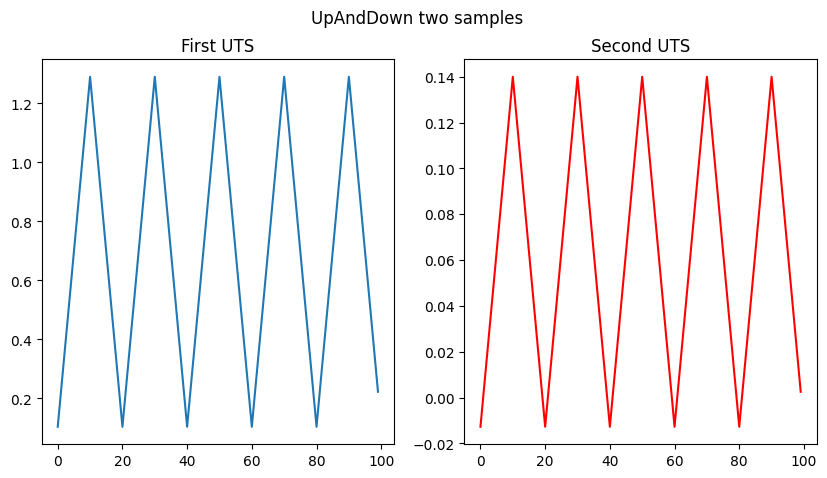

In [ ]:
# What the time series sequence length will be
seq_lengths = 100

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 2

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = 5

# How much std or noise we want to add to the time series
std = 0

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]

kwargs = {
    'num_samples': num_samples,
    'seq_length': seq_lengths,
    'num_cycles': num_cycles,
    'std': std,
    'starting_point': starting_point,
    'y_max_value': y_max_value
}
UTS = UpAndDown(**kwargs).generate_data()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('UpAndDown two samples')
ax1.plot(UTS[0])
ax1.set_title("First UTS")
ax2.plot(UTS[1], color = 'red')
ax2.set_title("Second UTS")
plt.show()

In [ ]:
print(colored("What we see here, is that the time serieses are looking quiet the same, they only differ in the min and max values", "blue"))
print(colored("Let's play with the parameters a little bit and see how they change the time series", "blue"))

What we see here, is that the time serieses are looking quiet the same, they only differ in the min and max values
Let's play with the parameters a little bit and see how they change the time series


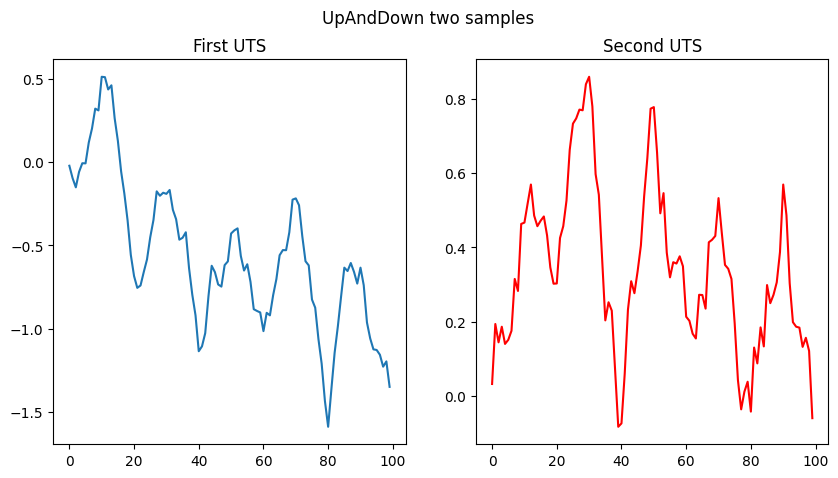

In [ ]:
# What the time series sequence length will be
seq_lengths = 100

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 2

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = 5

# How much std or noise we want to add to the time series
std = 2

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]

kwargs = {
    'num_samples': num_samples,
    'seq_length': seq_lengths,
    'num_cycles': num_cycles,
    'std': std,
    'starting_point': starting_point,
    'y_max_value': y_max_value
}
UTS = UpAndDown(**kwargs).generate_data()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('UpAndDown two samples')
ax1.plot(UTS[0])
ax1.set_title("First UTS")
ax2.plot(UTS[1], color = 'red')
ax2.set_title("Second UTS")
plt.show()

In [ ]:
print(colored("Changing the std only change the time series a lot!", "blue"))

Changing the std only change the time series a lot!


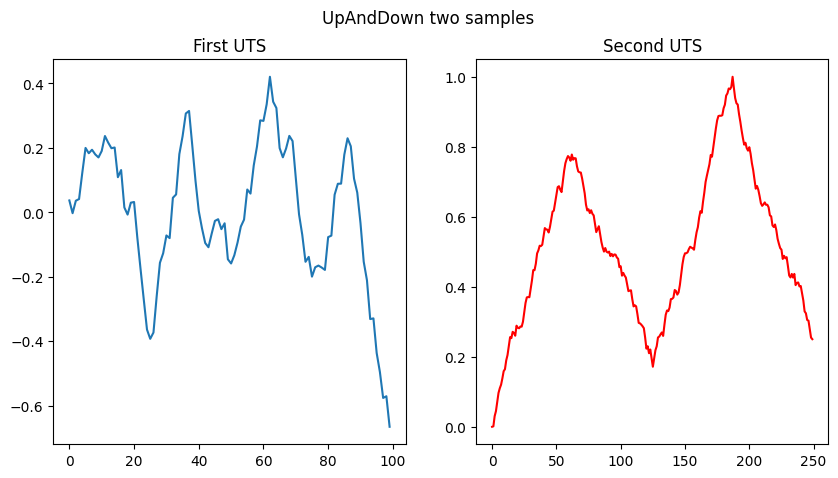

In [ ]:
# What the time series sequence length will be
seq_lengths = 100

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 1

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = 4

# How much std or noise we want to add to the time series
std = 2

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]

kwargs = {
    'num_samples': num_samples,
    'seq_length': seq_lengths,
    'num_cycles': num_cycles,
    'std': std,
    'starting_point': starting_point,
    'y_max_value': y_max_value
}
UTS1 = UpAndDown(**kwargs).generate_data()[0]

# What the time series sequence length will be
seq_lengths = 250

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 1

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = 2

# How much std or noise we want to add to the time series
std = 2

# a start and end range for the starting point of the time series
starting_point = [-5, 5]

# to what value we would like to normalized the final time series
y_max_value = [-5, 5]

kwargs = {
    'num_samples': num_samples,
    'seq_length': seq_lengths,
    'num_cycles': num_cycles,
    'std': std,
    'starting_point': starting_point,
    'y_max_value': y_max_value
}
UTS2 = UpAndDown(**kwargs).generate_data()[0]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('UpAndDown two samples')
ax1.plot(UTS1)
ax1.set_title("First UTS")
ax2.plot(UTS2, color = 'red')
ax2.set_title("Second UTS")
plt.show()

In [ ]:
print(colored("Now we can see this are completely different time series! however, they follow the same pattern of up and down", "blue"))
print(colored("Now for final plot, we will show how to make this generating process automated", "blue"))

Now we can see this are completely different time series! however, they follow the same pattern of up and down
Now for final plot, we will show how to make this generating process automated


#### Automated and diverse generation example

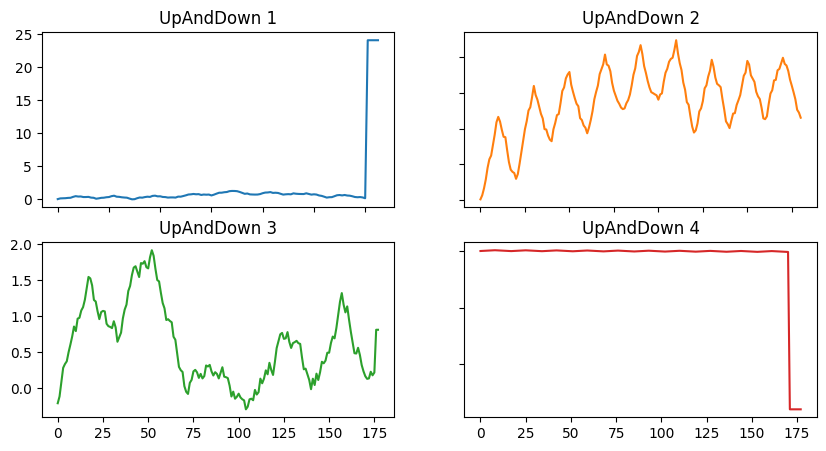

In [ ]:
# What the time series sequence length will be
seq_lengths = [100, 200]

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 4

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = [2, 10]

# How much std or noise we want to add to the time series
std = [0,3]

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]


dataset = []
for i in range(num_samples):
    kwargs = generate_random_kwargs(seq_lengths, num_cycles, std, starting_point, y_max_value)
    UTS = UpAndDown(**kwargs).generate_data()[0]
    dataset.append(UTS)

fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0, 0].plot(dataset[0])
axs[0, 0].set_title('UpAndDown 1')
axs[0, 1].plot(dataset[1], 'tab:orange')
axs[0, 1].set_title('UpAndDown 2')
axs[1, 0].plot(dataset[2], 'tab:green')
axs[1, 0].set_title('UpAndDown 3')
axs[1, 1].plot(dataset[3], 'tab:red')
axs[1, 1].set_title('UpAndDown 4')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
print(colored("Let's do the same for other sequence pattern", "blue"))
print(colored("Let's take HighPeak", "blue"))

Let's do the same for other sequence pattern
Let's take HighPeak


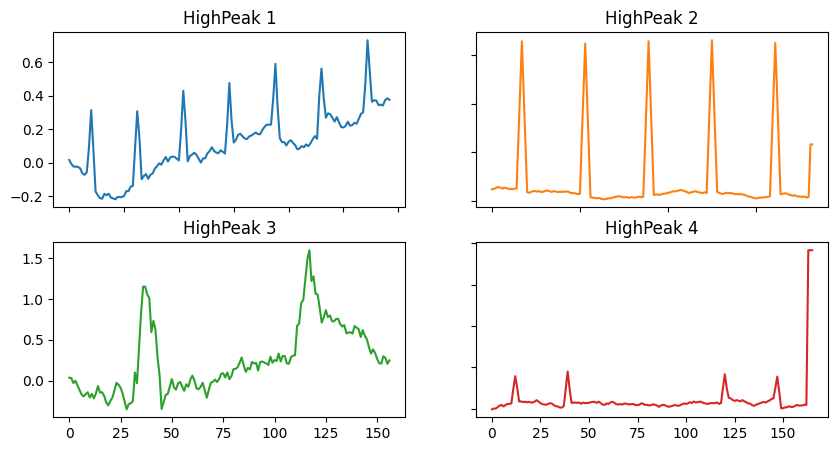

In [ ]:
# What the time series sequence length will be
seq_lengths = [100, 200]

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 4

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = [2, 10]

# How much std or noise we want to add to the time series
std = [0,3]

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]


dataset = []
for i in range(num_samples):
    kwargs = generate_random_kwargs(seq_lengths, num_cycles, std, starting_point, y_max_value)
    UTS = HighPeak(**kwargs).generate_data()[0]
    dataset.append(UTS)

fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0, 0].plot(dataset[0])
axs[0, 0].set_title('HighPeak 1')
axs[0, 1].plot(dataset[1], 'tab:orange')
axs[0, 1].set_title('HighPeak 2')
axs[1, 0].plot(dataset[2], 'tab:green')
axs[1, 0].set_title('HighPeak 3')
axs[1, 1].plot(dataset[3], 'tab:red')
axs[1, 1].set_title('HighPeak 4')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Create my own Pattern!!

In [ ]:
print(colored("Fianlly! explaination about how to create your own pattern", "blue"))
print(colored("Let's add a pattern that goes up and than goes staright", "blue"))
print(colored("We will add a new class to sequence same way as the others are defined, and just change there pattern", "blue"))
print(colored("I've added the lowest class: UpStraight", "blue"))
print(colored("his pattern is: ['U', 0.5, 45], ['S', 0.5, 0] ", "blue"))
print(colored("goint up half of the time in a 45 degrees amgle and then going staright for half of the time", "blue"))
print(colored("Let's look at the results", "blue"))

Fianlly! explaination about how to create your own pattern
Let's add a pattern that goes up and than goes staright
We will add a new class to sequence same way as the others are defined, and just change there pattern
I've added the lowest class: UpStraight
his pattern is: ['U', 0.5, 45], ['S', 0.5, 0] 
goint up half of the time in a 45 degrees amgle and then going staright for half of the time
Let's look at the results


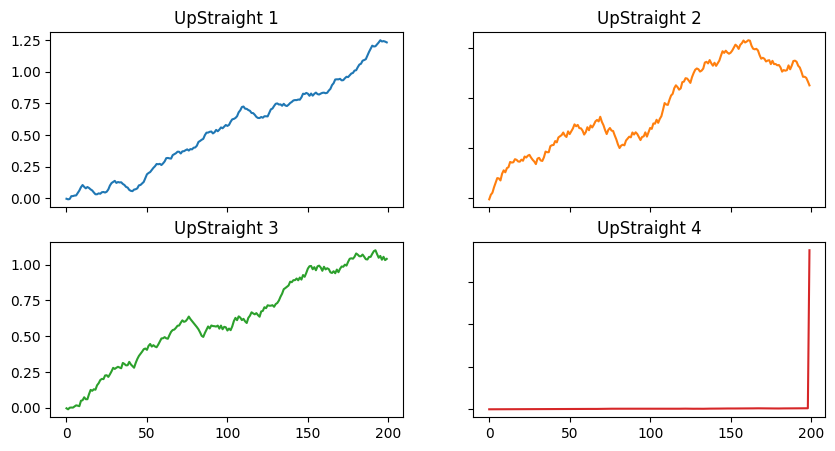

In [ ]:
# What the time series sequence length will be
seq_lengths = [200, 200]

# How many samples to generate - if over 50K, it's better to do in batches
num_samples = 4

# number of cycles we want our segment pattern to repeat itself, we will look on that later
num_cycles = [2, 10]

# How much std or noise we want to add to the time series
std = [0,3]

# a start and end range for the starting point of the time series
starting_point = [-1, 1]

# to what value we would like to normalized the final time series
y_max_value = [-2, 2]


dataset = []
for i in range(num_samples):
    kwargs = generate_random_kwargs(seq_lengths, num_cycles, std, starting_point, y_max_value)
    UTS = UpStraight(**kwargs).generate_data()[0]
    dataset.append(UTS)

fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0, 0].plot(dataset[0])
axs[0, 0].set_title('UpStraight 1')
axs[0, 1].plot(dataset[1], 'tab:orange')
axs[0, 1].set_title('UpStraight 2')
axs[1, 0].plot(dataset[2], 'tab:green')
axs[1, 0].set_title('UpStraight 3')
axs[1, 1].plot(dataset[3], 'tab:red')
axs[1, 1].set_title('UpStraight 4')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
print(colored("Simple as that, we created a new pattern!", "blue"))

Simple as that, we created a new pattern!


# Step 2 - producing Regression tasks (source task)

## Feature

In [ ]:
from abc import ABC, abstractmethod


class Feature(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def compute_feature(self, sequence):
        pass

## feature_set

In [ ]:
#from utils.Feature import Feature
from itertools import combinations
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import time


def get_all_possible_combinations(feature_set):
    return sum([list(map(list, combinations(feature_set, i))) for i in range(len(feature_set) + 1)], [])


def get_all_possible_combinations_for_10th():
    feature_set = [Maximum(),Minimum(), STD(), CrossMean(), Peaks()]
    return feature_set

def create_regression_tasks2(y_samples, feature_set):
    possible_combinations = get_all_possible_combinations(feature_set)
    print(possible_combinations)
    return


def create_regression_tasks(y_samples, feature_set):
    possible_combinations = get_all_possible_combinations(feature_set)
    y_train, y_train_combinations = [], []
    y_samples_flatten = y_samples.reshape(y_samples.shape[0],y_samples.shape[1])
    # For runtime saving - calculate each feature result only once and the concat if necessary
    feat_dic = {}
    for feature in feature_set:
        start = time.time()
        feat_dic[feature] = []
        y_true = []
        print("Computing feature {}".format(feature))
        for y_sample in y_samples_flatten:
            curr_feat = feature.compute_feature(y_sample.tolist())
            y_true.append(curr_feat)
        feat_dic[feature] = y_true

    for idx, comb in enumerate(possible_combinations):
        if len(comb) < 1:
            continue

        if idx % 10 == 0:
            print("{}/{}".format(idx,len(possible_combinations)))
        current_comb = []
        this_zip = []
        for feature in comb:
            this_zip.append(feat_dic[feature])
        for tup in list(zip(*this_zip)):
            y_true = []
            for val in tup:
                if type(val) == list:
                    y_true += curr_feat
                else:
                    y_true.append(val)
            current_comb.append(y_true)
        y_train_combinations.append(current_comb)
    y_train_combinations = np.array(y_train_combinations)
    return y_train_combinations


def create_classification_tasks(x, seqs):
    dic = {i: val for i,val in enumerate(seqs)}
    desc_dic = {val: i for i,val in enumerate(set(seqs))}
    num_classes = len(seqs)
    num_samples = int(x.shape[0]/num_classes)
    print(num_classes)
    print(num_samples)
    y = []
    for i in range(x.shape[0]):
        label = [0 for j in range(len(desc_dic))]
        curr_label = desc_dic[dic[int(i/num_samples)]]
        label[curr_label] = 1
        y.append(label)
    return np.array(y)


def create_regression_tastks_no_multi(y_samples, feature_set):
    y_s = [[] for i in range(y_samples.shape[0])]
    for idx, y_sample in enumerate(y_samples):
        for feature in feature_set:
            curr_feat = feature.compute_feature(y_sample.squeeze().tolist())
            if type(curr_feat) != list:
                curr_feat = [curr_feat]
            y_s[idx] += curr_feat

    return np.array([np.array(y) for y in y_s])


class Maximum(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        return max(sequence)


class Minimum(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        return min(sequence)


class STD(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        return np.std(sequence)

class Peaks(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        # prominence
        peaks, _ = find_peaks(sequence, prominence=0.1)
        return len(peaks)


class CrossMean(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        mean = np.mean(sequence)
        crosses = 0
        for i in range(len(sequence) - 1):
            if sequence[i] < mean < sequence[i + 1]:
                crosses += 1
            if sequence[i + 1] < mean < sequence[i]:
                crosses += 1
        return crosses


class Split10th(Feature):

     # overriding abstract method
    def compute_feature(self, sequence):
        regressions = []
        m = len(sequence) // 10
        splits = [sequence[i:i+m] for i in range(0, len(sequence), m)]
        tasks = get_all_possible_combinations_for_10th()
        for split in splits[:-1]:
            current_regressions = []
            for task in tasks:
                current_regressions.append(task.compute_feature(split))
            regressions += current_regressions
        return regressions



class summing_up(Feature):

    # overriding abstract method
    def compute_feature(self, sequence):
        return np.sum(sequence)

## Regression Tasks

In [ ]:
print(colored("Now, given a time series, we want to add his Regression task!", "blue"))
print(colored("Very simple, just choose the features, we chose the first 5 features", "blue"))

Now, given a time series, we want to add his Regression task!
Very simple, just choose the features, we chose the first 5 features


In [ ]:
#from utils.feature_set import Maximum, Minimum, STD, CrossMean, Peaks, Split10th
#import feature_set as fs

feature_set = [Maximum(), Minimum(), STD(), CrossMean(), Peaks()]
tasks = create_regression_tastks_no_multi(np.array(dataset), feature_set)
tasks = tasks.reshape(tasks.shape[0], 5)
tasks.shape

(4, 5)

In [ ]:
print(colored("That's great, we have 4 samples and 5 regression for each task", "blue"))
print(colored("Let's show how to add a feature, it's very simple, in the feature_set class", "blue"))
print(colored("Just add a new class the same way the others are defined. Lets add a feature that sum up the time series", "blue"))
print(colored("I just added a new one called 'summing_up' and override his compute_feature function with np.sum()", "blue"))

That's great, we have 4 samples and 5 regression for each task
Let's show how to add a feature, it's very simple, in the feature_set class
Just add a new class the same way the others are defined. Lets add a feature that sum up the time series
I just added a new one called 'summing_up' and override his compute_feature function with np.sum()


In [ ]:
#from utils.feature_set import summing_up
#import utils.feature_set as fs

feature_set = [summing_up()]
tasks = create_regression_tastks_no_multi(np.array(dataset), feature_set)
tasks = tasks.reshape(tasks.shape[0], 1)
tasks.shape

(4, 1)

In [ ]:
print(colored("Great! so let's create our final source task", "blue"))

Great! so let's create our final source task


In [ ]:
feature_set = [Maximum(), Minimum(), STD(), CrossMean(), Peaks()]
tasks = create_regression_tastks_no_multi(np.array(dataset), feature_set)
tasks = tasks.reshape(tasks.shape[0], 5)

# Step 3 - choosing CNN architecture

In [ ]:
print(colored("I chose CTN, just a simple CNN architcture but one can choose what ever he wants", "blue"))

I chose CTN, just a simple CNN architcture but one can choose what ever he wants


In [ ]:
from keras.layers import GlobalMaxPool1D, Activation, add, Concatenate,  Input,Dense, BatchNormalization, Dropout, Conv1D, MaxPool1D, GlobalAveragePooling1D, concatenate
from keras import Model

dataset = np.array(dataset)
source_dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], 1)
source_task = tasks


def CTN(x_shape, num_tasks):
    # Input layer
    input_layer = Input((None, x_shape[2]))

    # First layer
    convolution1 = Conv1D(filters=33, kernel_size=4, padding='same')(input_layer)
    convolution2 = Conv1D(filters=33, kernel_size=8, padding='same')(input_layer)
    convolution3 = Conv1D(filters=33, kernel_size=16, padding='same')(input_layer)
    convolution4 = Conv1D(filters=33, kernel_size=32, padding='same')(input_layer)
    convolution5 = Conv1D(filters=33, kernel_size=64, padding='same')(input_layer)
    concatted = Concatenate()([convolution1, convolution2, convolution3, convolution4, convolution5])
    batchnorm = BatchNormalization()(concatted)
    x = Activation(activation="relu")(batchnorm)

    convolution11 = Conv1D(filters=33, kernel_size=4, padding='same')(x)
    convolution21 = Conv1D(filters=33, kernel_size=8, padding='same')(x)
    convolution31 = Conv1D(filters=33, kernel_size=16, padding='same')(x)
    convolution41 = Conv1D(filters=33, kernel_size=32, padding='same')(x)
    convolution51 = Conv1D(filters=33, kernel_size=64, padding='same')(x)
    concatted2 = Concatenate()([convolution11, convolution21, convolution31, convolution41, convolution51])
    batchnorm2 = BatchNormalization()(concatted2)

    conv1 = Conv1D(filters=1,kernel_size=1)(input_layer)
    x = add([batchnorm2, conv1])
    x = Activation('relu')(x)

    # Second layer
    input_layer2 = x
    convolution1 = Conv1D(filters=33, kernel_size=4, padding='same')(input_layer2)
    convolution2 = Conv1D(filters=33, kernel_size=8, padding='same')(input_layer2)
    convolution3 = Conv1D(filters=33, kernel_size=16, padding='same')(input_layer2)
    convolution4 = Conv1D(filters=33, kernel_size=32, padding='same')(input_layer2)
    convolution5 = Conv1D(filters=33, kernel_size=64, padding='same')(input_layer2)
    concatted = Concatenate()([convolution1, convolution2, convolution3, convolution4, convolution5])
    batchnorm = BatchNormalization()(concatted)
    x = Activation(activation="relu")(batchnorm)

    convolution11 = Conv1D(filters=33, kernel_size=4, padding='same')(x)
    convolution21 = Conv1D(filters=33, kernel_size=8, padding='same')(x)
    convolution31 = Conv1D(filters=33, kernel_size=16, padding='same')(x)
    convolution41 = Conv1D(filters=33, kernel_size=32, padding='same')(x)
    convolution51 = Conv1D(filters=33, kernel_size=64, padding='same')(x)
    concatted2 = Concatenate()([convolution11, convolution21, convolution31, convolution41, convolution51])
    batchnorm2 = BatchNormalization()(concatted2)

    conv1 = Conv1D(filters=1,kernel_size=1)(input_layer2)
    x = add([batchnorm2, conv1])
    x = Activation('relu')(x)

    gap_layer = GlobalAveragePooling1D()(x)
    output = Dense(num_tasks, activation="linear")(gap_layer)
    model = Model(input_layer, output)
    model.compile(loss='MSE',
                  optimizer="adam",
                  metrics=['mse'])
    return model

model = CTN(source_dataset.shape, source_task.shape[1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 33)             165       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 33)             297       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, None, 33)             561       ['input_1[0][0]']             
                                                                                              

# Step 4 - pretraining

In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
X_train, X_test, y_train, y_test = train_test_split(source_dataset, source_task, test_size=0.2, random_state=41, shuffle=True)
history = model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=16, callbacks=[es], validation_data = (X_test, y_test))

# Step 5 - Fine-tune on new target dataset

## Load Adiac dataset from repo

In [ ]:
!git clone https://github.com/YR234/TL-for-TSC.git

Cloning into 'TL-for-TSC'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 125 (delta 6), reused 12 (delta 4), pack-reused 108
Receiving objects: 100% (125/125), 353.05 MiB | 39.18 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (59/59), done.


## load the dataset in model

In [ ]:
path = 'TL-for-TSC/reduced_dataset/Adiac/'
import pickle
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def load_data_reduce(dataset):
    with open(f'{path}x_train.pkl','rb') as f:
        x_train = pickle.load(f)
    with open(f'{path}x_test.pkl','rb') as f:
        x_test = pickle.load(f)
    with open(f'{path}y_train.pkl','rb') as f:
        y_train = pickle.load(f)
    with open(f'{path}y_test.pkl','rb') as f:
        y_test = pickle.load(f)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    uniqe = len(set(y_train))
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    y_train = to_categorical(encoded_Y, uniqe)

    uniqe = len(set(y_test))
    encoder = LabelEncoder()
    encoder.fit(y_test)
    encoded_Y = encoder.transform(y_test)
    y_test = to_categorical(encoded_Y, uniqe)

    return x_train, x_test, y_train, y_test


def adjust_model_to_target_dataset_and_task(loaded_model, num_class):
    pred = Dense(num_class, activation="softmax")(loaded_model.layers[-2].output)
    model = Model(inputs=loaded_model.input, outputs=pred)
    for layer in model.layers:
        layer.trainable = True
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

x_train, x_test, y_train, y_test = load_data_reduce('Adiac')

model = adjust_model_to_target_dataset_and_task(model, y_train.shape[1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, None, 33)             165       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, None, 33)             297       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, None, 33)             561       ['input_1[0][0]']             
                                                                                            

In [ ]:
print(colored("As you can see, the chamge I made was the last layer converted to a softmax layer with new number of tasks based on the target tasks", "blue"))
print(colored("Now, just training", "blue"))

As you can see, the chamge I made was the last layer converted to a softmax layer with new number of tasks based on the target tasks
Now, just training


In [ ]:
epochs = 5
history = model.fit(x_train, y_train, epochs=epochs, verbose=0, batch_size=16, validation_data = (x_test, y_test))

# Done!